In [41]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))



df = pd.read_csv(os.path.join(os.getcwd(), "../../data/total_4am.csv"), index_col=0)
# df = pd.read_csv(os.path.join(os.getcwd(), "../../data/dlr2.csv"), index_col=0)
# df = pd.read_csv(os.path.join(os.getcwd(), "../../temp_4.csv"), index_col=0)

df.reset_index(inplace=True)
df2 = df.copy()

In [42]:
import pandas as pd
import numpy as np
from performance import get_performance

# Calculate the price change
df["price_change"] = df["open"].diff()

# Calculate gains and losses
df["gain"] = np.where(df["price_change"] > 0, df["price_change"], 0)
df["loss"] = np.where(df["price_change"] < 0, -df["price_change"], 0)

# Calculate average gain and average loss over a 14-period window
window_length = 14
df["avg_gain"] = df["gain"].rolling(window=window_length).mean()
df["avg_loss"] = df["loss"].rolling(window=window_length).mean()

# Calculate RS and RSI
df["rs"] = df["avg_gain"] / df["avg_loss"]
df["rsi"] = 100 - (100 / (1 + df["rs"]))

# Set default signal to 0, no position
df["signal"] = 0
df.loc[(df["rsi"] >= 30) & (df["rsi"].shift(1) < 30), "signal"] = 1  # Buy signal
df.loc[(df["rsi"] <= 70) & (df["rsi"].shift(1) > 70), "signal"] = -1  # Sell signal




# Track highest price while holding a position
df["highest_price"] = df["open"].where(df["signal"] == 1)
df["highest_price"] = df["highest_price"].ffill()

# Calculate percentage change since the highest price
df["percent_change"] = (df["open"] - df["highest_price"]) / df["highest_price"] * 100

# # Exit conditions: stop loss (-5%) or sell signal (-1)
exit_condition = df["percent_change"] <= -5
df.loc[exit_condition, "signal"] = -1

# Initialize position: Set 1 on buy signal (signal == 1), NaN otherwise
df["position"] = np.where(df["signal"] == 1, 1, np.nan)
df["position"] = np.where(df["signal"] == -1, 0, np.nan)
df["position"] = df["position"].ffill()



# Calculate strategy returns without fees
df["strategy_returns"] = df["position"].shift(1) * df["open"].pct_change()

# Adjust for trading fees (buy with 0.2% fee, sell with 0.2% fee)
df["buy_price"] = df["open"].shift(1) * np.where(df["signal"].shift(1) == 1, 1.002, 1)
df["sell_price"] = df["open"] * np.where(df["position"].shift(1) == 1, 0.998, 1)

# Calculate strategy returns with fees
df["strategy_returns2"] = np.where(df["position"].shift(1) == 1, df["sell_price"] / df["buy_price"] - 1, 0)

# Calculate cumulative returns for the strategy (no fees)
df["cumulative_returns"] = (1 + df["strategy_returns"]).cumprod()

# Calculate cumulative returns for the strategy (with fees)
df["cumulative_returns2"] = (1 + df["strategy_returns2"]).cumprod()

# Calculate the benchmark returns (buy and hold strategy)
df["benchmark_returns"] = (1 + df["open"].pct_change()).cumprod()

# Drop the first row, as it contains NaN from the shift
df = df.dropna()

print(df)
df.to_csv("temp_gpt.csv")
# get_performance(df=df, title="rsi_cut_highest5%")

      index  day_starting_at_4am        open        high         low  \
31       31  2021-05-01 04:00:00  67146000.0  69386000.0  66965000.0   
32       32  2021-05-02 04:00:00  68602000.0  69297000.0  66803000.0   
33       33  2021-05-03 04:00:00  68020000.0  70999000.0  67795000.0   
34       34  2021-05-04 04:00:00  69606000.0  70490000.0  66940000.0   
35       35  2021-05-05 04:00:00  68030000.0  70007000.0  66500000.0   
...     ...                  ...         ...         ...         ...   
1232   1232  2024-08-14 04:00:00  84725000.0  85950000.0  82483000.0   
1233   1233  2024-08-15 04:00:00  82732000.0  83555000.0  81048000.0   
1234   1234  2024-08-16 04:00:00  81436000.0  83040000.0  79500000.0   
1235   1235  2024-08-17 04:00:00  82911000.0  83400000.0  82042000.0   
1236   1236  2024-08-18 04:00:00  82766000.0  83679000.0  82500000.0   

           close    volume_krw  volume_market  price_change       gain  ...  \
31    68601000.0  7.297448e+11   10635.934563     384400

In [43]:
import pandas as pd
import numpy as np
from performance import get_performance

# Assuming the dataframe is named df
# Calculate the price change
df2['price_change'] = df2['open'].diff()

# Calculate the gains and losses
df2['gain'] = np.where(df2['price_change'] > 0, df2['price_change'], 0)
df2['loss'] = np.where(df2['price_change'] < 0, -df2['price_change'], 0)

# Calculate the average gain and average loss
window_length = 14
df2['avg_gain'] = df2['gain'].rolling(window=window_length, min_periods=1).mean()
df2['avg_loss'] = df2['loss'].rolling(window=window_length, min_periods=1).mean()

# Calculate the RS (Relative Strength) and RSI
df2['rs'] = df2['avg_gain'] / df2['avg_loss']
df2['rsi'] = 100 - (100 / (1 + df2['rs']))

# Implement RSI strategy for long positions only
df2['signal'] = 0  # Default to no position
for i in range(1, len(df2)):
    # 매수 조건
    if (df2.loc[i, 'rsi'] >= 30) and (df2.loc[i-1, 'rsi'] < 30):
        df2.loc[i, 'signal'] = 1
    # 매도 조건
    elif (df2.loc[i, 'rsi'] <= 70) and (df2.loc[i-1, 'rsi'] > 70):
        df2.loc[i, 'signal'] = -1

# # Manage positions with stop loss, take profit, and sell signal
# df2['position'] = 0
# df2['entry_price'] = np.nan
# df2['exit_price'] = np.nan
# holding_position = False

# for i in range(1, len(df2)):
#     if df2['signal'].iloc[i] == 1 and not holding_position:
#         # Enter position
#         df2.loc[i, 'position'] = 1
#         df2.loc[i, 'entry_price'] = df2.loc[i, 'close']
#         holding_position = True
#     elif holding_position:
#         # Calculate percentage change since entry
#         entry_price = df2['entry_price'].iloc[i-1]
#         current_price = df2['close'].iloc[i]
#         percent_change = (current_price - entry_price) / entry_price * 100

#         if df2['signal'].iloc[i] == -1:  # Sell signal condition
#             # print(f"cond1 on{i}")
#             df2.loc[i, 'position'] = 0
#             df2.loc[i, 'exit_price'] = current_price
#             holding_position = False
#         elif percent_change <= -5:  # Stop loss condition
#             # print(f"cond2 on{i}")
#             df2.loc[i, 'position'] = 0
#             df2.loc[i, 'exit_price'] = current_price
#             holding_position = False
#         # elif percent_change >= 30:  # Take profit condition
#         #     print(f"cond3 on{i}")
#         #     df2['position'].iloc[i] = 0
#         #     df2['exit_price'].iloc[i] = current_price
#         #     holding_position = False
#         else:
#             # Continue holding the position if no sell conditions are met
#             # df2['position'].iloc[i] = df2['position'].iloc[i-1]
#             df2.loc[i, 'position'] = df2.loc[i-1, 'position']
#             # df2['entry_price'].iloc[i] = df2['entry_price'].iloc[i-1]
#             df2.loc[i, 'entry_price'] = df2.loc[i-1, 'entry_price']
#     else:
#         # No signal and no position
#         # df2['position'].iloc[i] = df2['position'].iloc[i-1]
#         df2.loc[i, 'position'] = df2.loc[i-1, 'position']

# Manage positions with stop loss, take profit, and sell signal
df2['position'] = 0
df2['highest_price'] = np.nan
df2['exit_price'] = np.nan
holding_position = False

for i in range(1, len(df2)):
    if df2['signal'].iloc[i] == 1 and not holding_position:
        # Enter position
        df2.loc[i, 'position'] = 1
        df2.loc[i, 'highest_price'] = df2.loc[i, 'open']
        holding_position = True
    elif holding_position:
        # Calculate percentage change since entry
        # df2['highest_price'].iloc[i] = max(df2['highest_price'].iloc[i-1], df2['open'].iloc[i])
        df2.loc[i, 'highest_price'] = max(df2.loc[i-1, 'highest_price'], df2.loc[i-1, 'open'])
        highest_price = df2['highest_price'].iloc[i]
        current_price = df2['open'].iloc[i]
        percent_change = (current_price - highest_price) / highest_price * 100

        if df2['signal'].iloc[i] == -1:  # Sell signal condition
            # print(f"cond1 on{i}")
            df2.loc[i, 'position'] = 0
            df2.loc[i, 'exit_price'] = current_price
            holding_position = False
        elif percent_change <= -5:  # Stop loss condition
            # print(f"cond2 on{i}")
            df2.loc[i, 'position'] = 0
            df2.loc[i, 'exit_price'] = current_price
            holding_position = False
        else:
            # Continue holding the position if no sell conditions are met
            df2.loc[i, 'position'] = df2.loc[i-1, 'position']

    else:
        # No signal and no position
        # df2['position'].iloc[i] = df2['position'].iloc[i-1]
        df2.loc[i, 'position'] = df2.loc[i-1, 'position']
        
# Calculate the strategy returns (only when in a long position)
df2['strategy_returns'] = df2['position'].shift(1) * df2['open'].pct_change()
df2['strategy_returns2'] = df2['strategy_returns']
        
for i in range(1, len(df2)):
    buy_price = df2.loc[i-1, "open"]
    buy_price_copy = buy_price
    sell_price = df2.loc[i, "open"]
    sell_price_copy = sell_price
    if df2.loc[i-1, 'position'] == 1 and df2.loc[i-1, 'signal'] == 1:
        # df2.loc[i, 'strategy_returns2'] = (df2.loc[i,'position'])/(df2.loc[i-1, 'position'] * 1.002) -1
        buy_price = df2.loc[i-1, "open"] * 1.002
    if df2.loc[i, 'position'] == 0 and df2.loc[i-1, 'position'] != 0:
        # df2.loc[i, 'strategy_returns2'] = (df2.loc[i,'position'] * 0.998)/(df2.loc[i-1, 'position']) -1
        sell_price = df2.loc[i, "open"] * 0.998
    
    if buy_price == buy_price_copy and sell_price == sell_price_copy:
        continue


    df2.loc[i, "strategy_returns2"] = sell_price/buy_price - 1

# Calculate the cumulative returns
df2['cumulative_returns'] = (1 + df2['strategy_returns']).cumprod()
df2["cumulative_returns2"] = (1 + df2['strategy_returns2']).cumprod()

# Calculate the benchmark cumulative returns (buy and hold strategy)
df2['benchmark_returns'] = (1 + df2['open'].pct_change()).cumprod()

# Display the results
# print(df2[['day_starting_at_4am', 'close', 'rsi', 'signal', 'position', 'cumulative_returns', 'benchmark_returns', 'entry_price', 'exit_price']].tail(10))

# df2.to_csv("../../results/rsi/rsi_with_stoploss_takeprofit_sell_signal.csv")

print(df2)
df2.to_csv("temp_hand_coded.csv")
# get_performance(df=df2, title="rsi_cut_highest5%")


      index  day_starting_at_4am        open        high         low  \
0         0  2021-03-31 04:00:00  70913000.0  72000000.0  70838000.0   
1         1  2021-04-01 04:00:00  71619000.0  73117000.0  70670000.0   
2         2  2021-04-02 04:00:00  72997000.0  74400000.0  71841000.0   
3         3  2021-04-03 04:00:00  73790000.0  75703000.0  73100000.0   
4         4  2021-04-04 04:00:00  74815000.0  75100000.0  71570000.0   
...     ...                  ...         ...         ...         ...   
1232   1232  2024-08-14 04:00:00  84725000.0  85950000.0  82483000.0   
1233   1233  2024-08-15 04:00:00  82732000.0  83555000.0  81048000.0   
1234   1234  2024-08-16 04:00:00  81436000.0  83040000.0  79500000.0   
1235   1235  2024-08-17 04:00:00  82911000.0  83400000.0  82042000.0   
1236   1236  2024-08-18 04:00:00  82766000.0  83679000.0  82500000.0   

           close    volume_krw  volume_market  price_change       gain  ...  \
0     71672000.0  8.072377e+10    1128.289061           

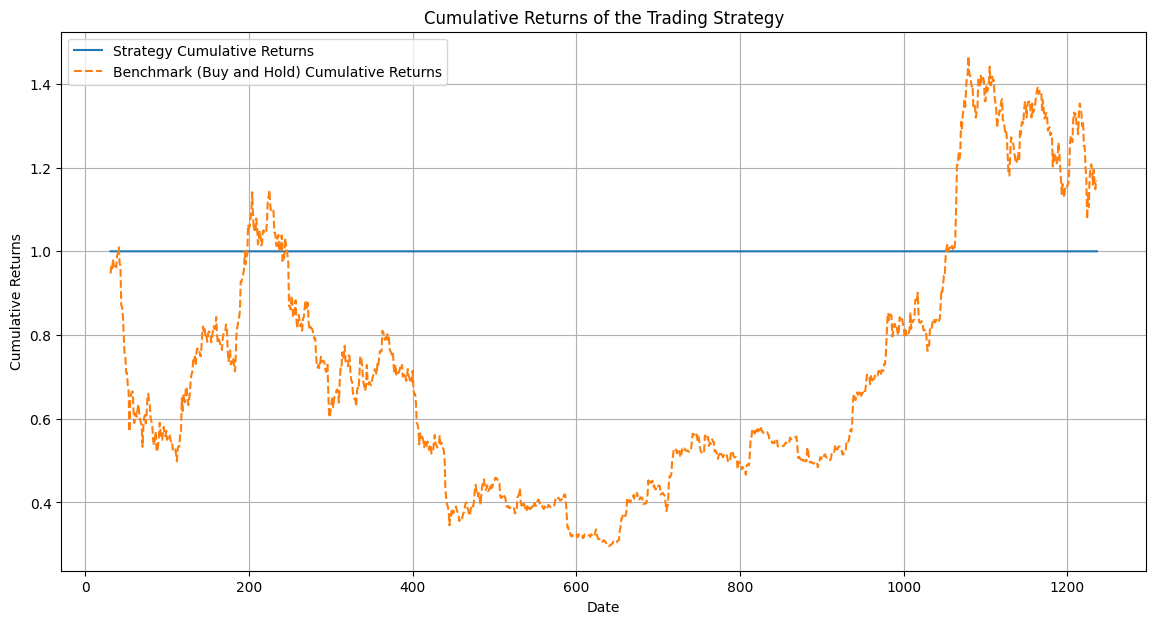

In [44]:
import matplotlib.pyplot as plt
# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(df['cumulative_returns2'], label='Strategy Cumulative Returns')
plt.plot(df['benchmark_returns'], label='Benchmark (Buy and Hold) Cumulative Returns', linestyle='--')
plt.title('Cumulative Returns of the Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()
